In [1]:
%matplotlib inline
import pickle

import pandas as pd
import numpy as np

from scikitplot.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, auc, roc_curve

from catboost import CatBoostClassifier
from transformer import transform_df

**Загружаем данные**

In [2]:
df = pd.read_csv('data/credit_train.csv', dtype={'tariff_id':'string'})
df.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,52372,M,38,MAR,SPC,"12168,00",10,1.1,"0,308454",GRD,ОБЛ ВОЛОГОДСКАЯ,25000.0,0.0,0.0,0
1,75213,F,36,MAR,SPC,"17738,00",10,1.1,"0,498147",GRD,ОБЛ БЕЛГОРОДСКАЯ,25000.0,4.0,0.0,0
2,119931,M,23,UNM,SPC,"26489,00",10,1.1,"0,431980",SCH,ЧЕЛЯБИНСКАЯ ОБЛ,25000.0,NaN,NaN,0
3,134365,M,24,UNM,SPC,"20379,00",12,1.6,"0,770546",GRD,РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ,50000.0,NaN,NaN,1
4,138695,F,47,MAR,SPC,"12019,00",10,1.6,"0,617275",SCH,УЛЬЯНОВСКАЯ ОБЛ,18000.0,0.0,0.0,0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
client_id,136596.0,85373.933095,49297.673514,1.0,42711.75,85314.5,128064.25,170745.0
age,136596.0,36.514876,10.554118,18.0,28.00,34.0,43.00,71.0
credit_month,136596.0,10.978799,3.534678,3.0,10.00,10.0,12.00,36.0
monthly_income,136595.0,40142.138570,25058.534874,5000.0,25000.00,35000.0,50000.00,950000.0
credit_count,129231.0,2.106623,1.777846,0.0,1.00,2.0,3.00,21.0
overdue_credit_count,129231.0,0.046382,0.212034,0.0,0.00,0.0,0.00,3.0
open_account_flg,136596.0,0.176030,0.380847,0.0,0.00,0.0,0.00,1.0


**Распределение клиентов на тех кто открыл кредитный счет**

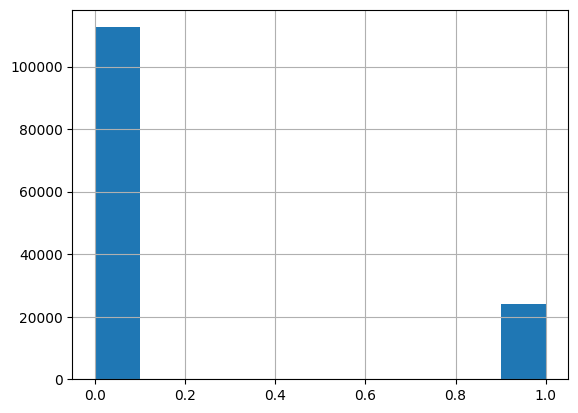

In [4]:
df['open_account_flg'].hist();

**Начальная обработка датасета**
1. Удаляем не нужные колонки ('client_id', 'living_region')
2. Меняем тип колонок на числовой ('credit_sum', 'score_shk')
3. Изменяем представление колонки 'gender' на бинарное. Переименовываем в 'female'

In [5]:
transform_df(df)

**Проверяем датасет на пустые значения**

In [6]:
df.isnull().sum()

female                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
monthly_income             1
credit_count            7365
overdue_credit_count    7365
open_account_flg           0
dtype: int64

**Заполняем пропуски медианными значениями**

In [7]:
imputer = SimpleImputer(strategy='median')

for column in ['credit_count', 'overdue_credit_count', 'monthly_income']:
	df[column] = imputer.fit_transform(df[column].values.reshape(-1, 1))

In [8]:
df.isnull().sum()

female                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
education               0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
dtype: int64

**Разделяем датасет на метки и признаки**

In [9]:
y = df['open_account_flg']
X = df.drop(('open_account_flg'), axis=1) 

**Разделяем данные на тренировочные и проверочные**

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=15
    )
X_train.shape[0], X_test.shape[0]

(95617, 40979)

**Инициализируем модель для Классификации и тренируем ее**

In [11]:
cb_clf = CatBoostClassifier(
    random_state=17, 
    depth=4, 
    iterations=1000,
    verbose=False
    )

In [12]:
cb_clf.fit(
    X_train, 
    y_train, 
    cat_features=['marital_status', 'job_position', 'education', 'tariff_id']
    );

Пару слов о том почему была выбрана эта модель:
1. Данная модель показала наилучший результат по сравнению с другими моделями такими как RandomForestClassifier, LogisticRegression, LinearSVC, SGDClassifier
2. Модель имеет встроеную обработку категориальных признаков
3. Быстрая скорость обучения

In [13]:
y_pred_proba = cb_clf.predict_proba(X_test)[:, 1]

**Проверяем модель на качество**

In [14]:
roc_auc_score(y_test, y_pred_proba)

0.7605303614033498

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

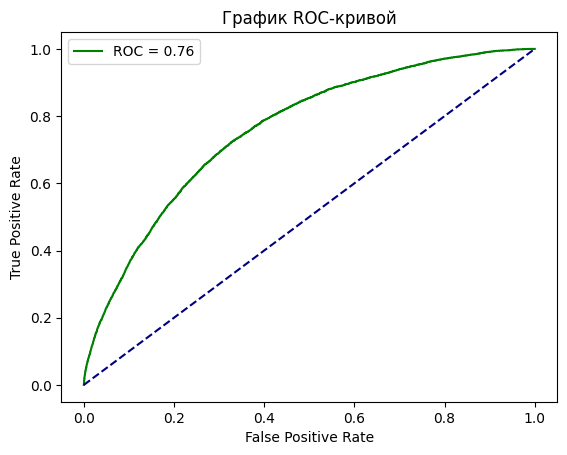

In [16]:
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', label='ROC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривой');
plt.legend();

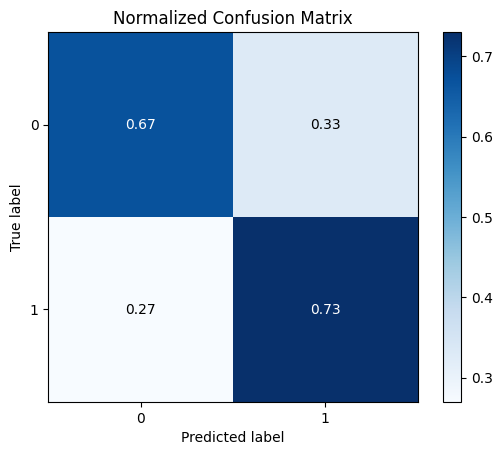

In [17]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred_proba_17 = (y_pred_proba >= optimal_threshold).astype(bool)
plot_confusion_matrix(y_test, y_pred_proba_17, normalize=True);

In [18]:
from sklearn.metrics import f1_score

f1_score(y_test, (y_pred_proba >= optimal_threshold).astype(bool))

0.44198707043211977

In [19]:
roc_auc_score(y_test, y_pred_proba_17)

0.6977493312092524

**Сохраняем модель для дальнейшего пользования**

In [20]:
with open('model', 'wb') as files:
    pickle.dump(cb_clf, files)